### Спасибо за предоставленный ноутбук [Элине](https://www.kaggle.com/elinaandriyanova)!

# Install & Import

In [1]:
#!pip install -qqq ipyplot

In [2]:
import os
import pywt
import numpy as np 
import pandas as pd 
import glob
from ipyplot import plot_images
import cv2
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision import models, transforms, datasets
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_auc_score, accuracy_score

# Load data

In [3]:
df_train = pd.read_csv('D:/kaggle_data/shift_cv_winter_2022/train.csv')
print(len(df_train))

2664


In [4]:
path = 'D:/kaggle_data/shift_cv_winter_2022/train/train/'

df_train['filename'] = df_train['filename'].apply(lambda x: path + x)
df_train.head()

,filename,blur
0,D:/kaggle_data/shift_cv_winter_2022/train/trai...,0.0
1,D:/kaggle_data/shift_cv_winter_2022/train/trai...,0.0
2,D:/kaggle_data/shift_cv_winter_2022/train/trai...,0.0
3,D:/kaggle_data/shift_cv_winter_2022/train/trai...,0.0
4,D:/kaggle_data/shift_cv_winter_2022/train/trai...,1.0


In [5]:
test_imgs = []
for file in glob.glob("D:/kaggle_data/shift_cv_winter_2022/test/test/*.jpg"):
    test_imgs.append({'filename': file})
df_test = pd.DataFrame(test_imgs)
print("Test images: ", len(df_test))

Test images:  774


In [6]:
train_blur = df_train[df_train["blur"]==1]
train_sharp = df_train[df_train["blur"]==0]

print("blur images:", len(train_blur))
print("sharp images:", len(train_sharp))

blur images: 1297
sharp images: 1367


# Show several sharp images

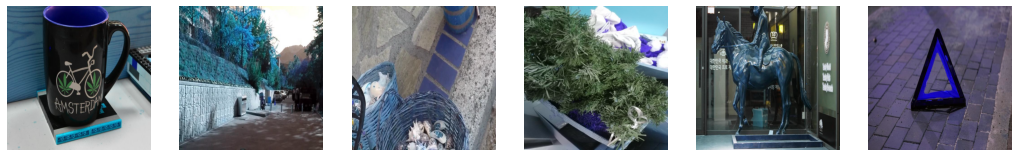

In [7]:
images = train_sharp.filename.sample(6).tolist()
#plot_images(images, max_images=10,img_width=220,force_b64=True)
plt.figure(figsize=(18, 6))
for i, x in enumerate(images):
    one_image = cv2.imread(x)
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(one_image)
plt.show()

# Show several blur images

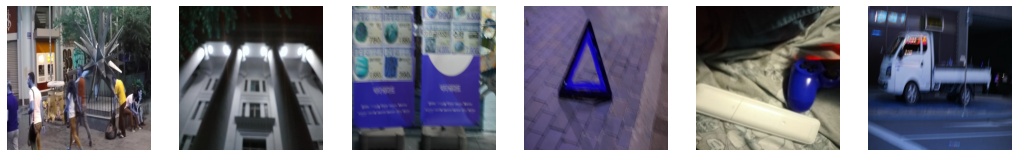

In [8]:
images = train_blur.filename.sample(6).tolist()
#plot_images(images,max_images=10,img_width=220,force_b64=True)
plt.figure(figsize=(18, 6))
for i, x in enumerate(images):
    one_image = cv2.imread(x)
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(one_image)
plt.show()

# Create custom dataset and dataloader

In [9]:
def read_image_gray(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY) 

In [10]:
class CustomDataset(Dataset):
    def __init__(self, df):
        self.df = df
               
    def __len__(self):
        return len(self.df)


class CustomDatasetTrain(CustomDataset):
    def __init__(self, df, transform=None):
        super().__init__(df)
        self.transform = transform
   
    def __getitem__(self,idx):
        image = self.df.filename.iloc[idx]
        image = read_image_gray(image)
        if self.transform:
            image = self.transform(image)
        label = self.df.blur.iloc[idx]
        return {'image': image, 'label': label}


class CustomDatasetTest(CustomDataset):
    def __init__(self, df, transform=None):
            super().__init__(df)
            self.transform = transform

    def __getitem__(self,idx):
        image = self.df.filename.iloc[idx]
        image = read_image_gray(image)
        if self.transform:
            image = self.transform(image)
        return {'image': image}

In [11]:
#resizing and normalizing images
transformed = transforms.Compose([
                                  transforms.ToPILImage(),
                                  #transforms.Resize((320, 320)),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5), (0.5)),
                                ])

BATCH_SIZE = 32

train_dataset = CustomDatasetTrain(df_train)

train_dataloader = DataLoader(
            dataset=train_dataset,
            batch_size=BATCH_SIZE,
            ),

# Some functions for calculating blur measure 

In [12]:
def calc_fft_measure(gray_img, size=40):
    """ Определение заблюренности изображения с помощью Fourier transform:

    - Изображение переводится в частотный спектр с помощью fft, производится сдвиг начала координат и
    зануляется низкочастотный спектр.
    - Частотный спектр переводится обратно в изображение с помощью inverse fft.
    - Считается магнитуда, определяется уровень заблюренности картинки.
    Чем больше полученное значение, тем более размыто изображение
    """
    gray_img = gray_img.squeeze()
    (n, h, w) = gray_img.shape
    (cx, cy) = (int(w / 2.0), int(h / 2.0))
    fft = np.fft.fft2(gray_img, axes=(1, 2))
    fftShift = np.fft.fftshift(fft, axes=(1, 2))

    fftShift[:, cy - size : cy + size, cx - size : cx + size] = 0
    fftShift = np.fft.ifftshift(fftShift, axes=(1, 2))
    recon = np.fft.ifft2(fftShift, axes=(1, 2))
    
    magnitude = 20 * np.log(np.abs(recon))
    mean = 1/np.average(magnitude, axis=(1, 2))

    return mean

In [13]:
def calc_tv_measure(gray_img):
    """ Определение заблюренности изображения с помощью Total Variation:

    Берется отношение суммы квадратов разницы между соседними писелями к сумме модулей разницы.
    Чем больше полученное значение, тем более размыто изображение

    """
    gray_img = gray_img.squeeze().detach().clone()
    gray_img = gray_img[:, gray_img.shape[1]//4:3*gray_img.shape[1]//4,gray_img.shape[2]//4:3*gray_img.shape[2]//4]
    
    w_variance = torch.sum(torch.pow(gray_img[:, :, 1:] - gray_img[:, :, :-1], 2), dim=[1, 2])
    h_variance = torch.sum(torch.pow(gray_img[:, 1:, :] - gray_img[:, :-1, :], 2), dim=[1, 2])

    l2_score = (h_variance + w_variance)

    w_variance = torch.sum(torch.abs(gray_img[:, :, 1:] - gray_img[:, :, :-1]), dim=[1, 2])
    h_variance = torch.sum(torch.abs(gray_img[:, 1:, :] - gray_img[:, :-1, :]), dim=[1, 2])
    
    l1_score = (h_variance + w_variance)
    
    tv_measure = l1_score/l2_score
    
    return tv_measure

In [14]:
# thanks for implementation https://github.com/pedrofrodenas
def hwt_measure(gray_img, threshold):

    hwt_list = []
    gray_img = gray_img.squeeze()

    for Y in gray_img:
        M, N = Y.shape
        # Crop input image to be 3 divisible by 2
        Y = Y[0:int(M/16)*16, 0:int(N/16)*16]
        
        # Step 1, compute Haar wavelet of input image
        LL1,(LH1,HL1,HH1)= pywt.dwt2(Y, 'haar')
        # Another application of 2D haar to LL1
        LL2,(LH2,HL2,HH2)= pywt.dwt2(LL1, 'haar') 
        # Another application of 2D haar to LL2
        LL3,(LH3,HL3,HH3)= pywt.dwt2(LL2, 'haar')
        
        # Construct the edge map in each scale Step 2
        E1 = np.sqrt(np.power(LH1, 2)+np.power(HL1, 2)+np.power(HH1, 2))
        E2 = np.sqrt(np.power(LH2, 2)+np.power(HL2, 2)+np.power(HH2, 2))
        E3 = np.sqrt(np.power(LH3, 2)+np.power(HL3, 2)+np.power(HH3, 2))
        
        M1, N1 = E1.shape

        # Sliding window size level 1
        sizeM1 = 8
        sizeN1 = 8
        
        # Sliding windows size level 2
        sizeM2 = int(sizeM1/2)
        sizeN2 = int(sizeN1/2)
        
        # Sliding windows size level 3
        sizeM3 = int(sizeM2/2)
        sizeN3 = int(sizeN2/2)
        
        # Number of edge maps, related to sliding windows size
        N_iter = int((M1/sizeM1)*(N1/sizeN1))
        
        Emax1 = np.zeros((N_iter))
        Emax2 = np.zeros((N_iter))
        Emax3 = np.zeros((N_iter))

        count = 0
        
        # Sliding windows index of level 1
        x1 = 0
        y1 = 0
        # Sliding windows index of level 2
        x2 = 0
        y2 = 0
        # Sliding windows index of level 3
        x3 = 0
        y3 = 0
        
        # Sliding windows limit on horizontal dimension
        Y_limit = N1-sizeN1
        
        try:
            while count < N_iter:
                # Get the maximum value of slicing windows over edge maps 
                # in each level
                Emax1[count] = np.max(E1[x1:x1+sizeM1,y1:y1+sizeN1])
                Emax2[count] = np.max(E2[x2:x2+sizeM2,y2:y2+sizeN2])
                Emax3[count] = np.max(E3[x3:x3+sizeM3,y3:y3+sizeN3])
                
                # if sliding windows ends horizontal direction
                # move along vertical direction and resets horizontal
                # direction
                if y1 == Y_limit:
                    x1 = x1 + sizeM1
                    y1 = 0
                    
                    x2 = x2 + sizeM2
                    y2 = 0
                    
                    x3 = x3 + sizeM3
                    y3 = 0
                    
                    count += 1
                
                # windows moves along horizontal dimension
                else:
                        
                    y1 = y1 + sizeN1
                    y2 = y2 + sizeN2
                    y3 = y3 + sizeN3
                    count += 1
        except ValueError:
            pass
        
        # Step 3
        EdgePoint1 = Emax1 > threshold;
        EdgePoint2 = Emax2 > threshold;
        EdgePoint3 = Emax3 > threshold;
        
        # Rule 1 Edge Pojnts
        EdgePoint = EdgePoint1 + EdgePoint2 + EdgePoint3
        
        n_edges = EdgePoint.shape[0]
        
        # Rule 2 Dirak-Structure or Astep-Structure
        DAstructure = (Emax1[EdgePoint] > Emax2[EdgePoint]) * (Emax2[EdgePoint] > Emax3[EdgePoint]);
        
        # Rule 3 Roof-Structure or Gstep-Structure
        RGstructure = np.zeros((n_edges))

        for i in range(n_edges):
            if EdgePoint[i] == 1:
                if Emax1[i] < Emax2[i] and Emax2[i] < Emax3[i]:
                    RGstructure[i] = 1
                    
        # Rule 4 Roof-Structure
        RSstructure = np.zeros((n_edges))

        for i in range(n_edges):
            if EdgePoint[i] == 1:
                if Emax2[i] > Emax1[i] and Emax2[i] > Emax3[i]:
                    RSstructure[i] = 1

        # Rule 5 Edge more likely to be in a blurred image 
        BlurC = np.zeros((n_edges));

        for i in range(n_edges):
            if RGstructure[i] == 1 or RSstructure[i] == 1:
                if Emax1[i] < threshold:
                    BlurC[i] = 1                        
            
        # Step 6
        Per = np.sum(DAstructure)/np.sum(EdgePoint)
        
        # Step 7
        if (np.sum(RGstructure) + np.sum(RSstructure)) == 0:
            BlurExtent = 100
        else:
            BlurExtent = np.sum(BlurC) / (np.sum(RGstructure) + np.sum(RSstructure))
        
        hwt_list.append(BlurExtent)

    return hwt_list

In [15]:
def lap_measure(gray_img):
    list_lap = []
    gray_img = gray_img.squeeze().numpy()
    for i in gray_img:
        list_lap.append(cv2.Laplacian(i, cv2.CV_64F).var())
    return list_lap

# Calculate measures

In [16]:
tv_measures = []
fft_measures = []
lap_measures = []
hwt_measures = []

for dl in train_dataloader:
    for batch in tqdm(dl):
        tv_measures.extend(calc_tv_measure(batch['image']).tolist())
        fft_measures.extend(calc_fft_measure(batch['image']).tolist())
        lap_measures.extend(lap_measure(batch['image']))
        hwt_measures.extend(hwt_measure(batch['image'], 100))

df_train['tv_measure'] = tv_measures
df_train['fft_measure'] = fft_measures   
df_train['lap_measure'] = lap_measures
df_train['hwt_measure'] = hwt_measures

 57%|█████▋    | 48/84 [02:51<02:03,  3.42s/it]C:\Users\kinkp\AppData\Local\Temp\ipykernel_11128\3755426898.py:131: RuntimeWarning: invalid value encountered in long_scalars
  Per = np.sum(DAstructure)/np.sum(EdgePoint)
100%|██████████| 84/84 [04:57<00:00,  3.55s/it]


In [17]:
#let's try to apply threshold to blur measures
THRESHOLD = 0.94
#df_train['lap_measure_thresh'] = (df_train['lap_measure'] < THRESHOLD).astype(int)
df_train['hwt_measure_thresh'] = (df_train['hwt_measure'] > THRESHOLD).astype(int)

# Calculate ROC AUC metric on train dataset

In [18]:
print('ROC AUC using Total Variation:', np.round(roc_auc_score(df_train.blur.tolist(), df_train.tv_measure.tolist()), 5))
print('ROC AUC using Furrier Trasform:', np.round(roc_auc_score(df_train.blur.tolist(), df_train.fft_measure.tolist()), 5))
#because LAP measure take 0 as a blur, subtract maximum from all items       
print('ROC AUC using LAP Trasform:', np.round(roc_auc_score(df_train.blur.tolist(), (df_train['lap_measure'].max() - df_train['lap_measure']).tolist()), 5)) 
print('ROC AUC using HWT Trasform:', np.round(roc_auc_score(df_train.blur.tolist(), (df_train['hwt_measure']).tolist()), 5))  
print('ROC AUC using HWT Trasform + Threshold:', np.round(roc_auc_score(df_train.blur.tolist(), (df_train['hwt_measure_thresh']).tolist()), 5))

ROC AUC using Total Variation: 0.79844
ROC AUC using Furrier Trasform: 0.75522
ROC AUC using LAP Trasform: 0.93439
ROC AUC using HWT Trasform: 0.85773
ROC AUC using HWT Trasform + Threshold: 0.73501


# Predict on test dataset

In [19]:
#HWT transform showed the best result that it will be a blur measure in test dataset
test_dataset = CustomDatasetTest(df_test)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE),

tv_measures = []
fft_measures = []
lap_measures = []
hwt_measures = []

for dl in test_dataloader:
    for batch in tqdm(dl):
        #tv_measures.extend(calc_tv_measure(batch['image']).tolist())
        #fft_measures.extend(calc_fft_measure(batch['image']).tolist())
        #lap_measures.extend(lap_measure(batch['image']))
        hwt_measures.extend(hwt_measure(batch['image'], 100))

#df_test['blur'] = (df_train['lap_measure'] < THRESHOLD).astype(int)
#df_test['blur'] = df_train['lap_measure'].max() - df_train['lap_measure']
df_test['blur'] = hwt_measures
df_test['filename'] = df_test['filename'].apply(lambda x : os.path.split(x)[1])
df_test.to_csv('D:/kaggle_data/shift_cv_winter_2022/blur_submission.csv', index=False)

 12%|█▏        | 3/25 [00:05<00:43,  1.97s/it]C:\Users\kinkp\AppData\Local\Temp\ipykernel_11128\3755426898.py:131: RuntimeWarning: invalid value encountered in long_scalars
  Per = np.sum(DAstructure)/np.sum(EdgePoint)
100%|██████████| 25/25 [00:44<00:00,  1.80s/it]


In [20]:
df_test.sample(10)

,filename,blur
76,cikwqtdkyvxoultdcuqt.jpg,0.953975
650,vunwvyjnagdgamsrzgin.jpg,0.727498
499,qejvwybanfltsrksevdp.jpg,0.883629
367,mgfhevufmcljirfvsjet.jpg,0.960591
772,zytbqidsjtourxzyfasw.jpg,0.908353
54,brbntfonfyzzpubepugm.jpg,1.000000
564,stzlxqyhnrmajkacdtjw.jpg,0.891579
400,nflipvrpydcifdwlnttq.jpg,0.986275
105,dhgqbhtozuesxwyconpq.jpg,1.000000
461,oyhrnzmcrjovzsuhczdy.jpg,0.978541
